In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

In [2]:
import glob

In [3]:
import tensorflow as tf

/opt/anaconda3/envs/tensorflow-python3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tensorflow-python3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tensorflow-python3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tensorflow-pyt

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.python.keras.applications import ResNet50, VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.applications.resnet50 import preprocess_input as resnet_pi
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
%matplotlib inline 

Using TensorFlow backend.


In [10]:
'''from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
'''

In [5]:
from tensorflow.python.keras import backend as K

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [8]:
!`pwd`

/usr/bin/sh: /home/jupyter/work/maonx/sources/TensorFlow-Examples/tensorflow_v1/notebooks/3_NeuralNetworks/chicken: Is a directory


In [7]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 3
SAMPLE_SIZE = 20000
PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
TRAIN_FOLDER = '/home/jupyter/work/maonx/sources/TensorFlow-Examples/tensorflow_v1/notebooks/3_NeuralNetworks/chicken/'
TEST_FOLDER =  './test/'
IMG_SIZE = 224
RESNET_WEIGHTS_PATH = '/home/jupyter/work/maonx/sources/TensorFlow-Examples/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
VGG_WEIGHTS_PATH = '/home/jupyter/work/maonx/sources/TensorFlow-Examples/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('/')[-2]
    if pet == 'Gacon': return [1,0,0]
    elif pet == 'Gatrong': return [0,1,0]
    elif pet == 'Gamai': return [0, 0, 1]

In [9]:
def process_data(data_image_list, DATA_FOLDER, pi_func, isTrain=True):
    X = []
    Y = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        try:
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            img = pi_func(img)
            X.append(np.array(img))
            Y.append(np.array(label))
        except Exception as es:
            print(path)
            #raise es
    #shuffle(data_df)
    return X, Y

In [10]:
types = ['*.jpg', '*.jpeg','*.gif', '*.webp' ] # the tuple of file types
train_image_list = []
labels_track = []
Dir = "./Gacon"
for files in types:
    train_image_list.extend(glob.glob(os.path.join(Dir, files)))
labels_track.append(len(train_image_list))
Dir = "./Gatrong"
for files in types:
    train_image_list.extend(glob.glob(os.path.join(Dir, files)))
labels_track.append(len(train_image_list)-np.sum(labels_track))
Dir = "./Gamai"
for files in types:
    train_image_list.extend(glob.glob(os.path.join(Dir, files)))
labels_track.append(len(train_image_list)-np.sum(labels_track))

In [77]:
X, Y = process_data(train_image_list, TRAIN_FOLDER, preprocess_input)

 79%|███████▉  | 718/904 [00:02<00:00, 265.80it/s]

/home/jupyter/work/maonx/sources/TensorFlow-Examples/tensorflow_v1/notebooks/3_NeuralNetworks/chicken/./Gatrong/Gatrong (1).gif


100%|██████████| 904/904 [00:02<00:00, 312.42it/s]


In [78]:
X = np.array(X)
Y = np.array(Y)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
     X, Y, test_size=0.2, random_state=42)

In [14]:
del X
del Y
X = None
Y = None

In [15]:
import gc
gc.collect()

114

### Model

In [84]:
K.clear_session()

In [18]:
del model

NameError: name 'model' is not defined

In [85]:
model = VGG16(include_top=False,  input_shape=(IMG_SIZE, IMG_SIZE, 3), weights=VGG_WEIGHTS_PATH)
#model = ResNet50(include_top=False,  input_shape=(IMG_SIZE, IMG_SIZE, 3), weights=RESNET_WEIGHTS_PATH)
for layer in model.layers:
    if str(type(layer)) == "<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>":
        layer.trainable = False
# add new classifier layers
gp = GlobalAveragePooling2D()(model.layers[-1].output)
flat1 = Flatten()(gp)
output = Dense(NUM_CLASSES, activation='softmax')(flat1)
# define new model
model = Model(inputs=model.inputs, outputs=output)

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

In [87]:
history = model.fit(X_train, y_train, epochs=40, batch_size=50, verbose=2, validation_split=0.1)

Train on 649 samples, validate on 73 samples
Epoch 1/20
649/649 - 5s - loss: 4.2405 - acc: 0.3667 - val_loss: 2.5819 - val_acc: 0.5479
Epoch 2/20
649/649 - 2s - loss: 2.0202 - acc: 0.5655 - val_loss: 1.3515 - val_acc: 0.6164
Epoch 3/20
649/649 - 2s - loss: 1.2684 - acc: 0.6995 - val_loss: 1.1754 - val_acc: 0.7260
Epoch 4/20
649/649 - 2s - loss: 0.9230 - acc: 0.7735 - val_loss: 0.8061 - val_acc: 0.8219
Epoch 5/20
649/649 - 2s - loss: 0.7247 - acc: 0.8089 - val_loss: 0.7635 - val_acc: 0.8493
Epoch 6/20
649/649 - 2s - loss: 0.5963 - acc: 0.8382 - val_loss: 0.7132 - val_acc: 0.8082
Epoch 7/20
649/649 - 2s - loss: 0.5207 - acc: 0.8659 - val_loss: 0.7046 - val_acc: 0.8493
Epoch 8/20
649/649 - 2s - loss: 0.4553 - acc: 0.8613 - val_loss: 0.7243 - val_acc: 0.8082
Epoch 9/20
649/649 - 2s - loss: 0.3909 - acc: 0.8752 - val_loss: 0.6571 - val_acc: 0.8219
Epoch 10/20
649/649 - 2s - loss: 0.3328 - acc: 0.9014 - val_loss: 0.6602 - val_acc: 0.8356
Epoch 11/20
649/649 - 2s - loss: 0.2994 - acc: 0.8968 

In [88]:
Y_pred = model.predict(X_test)

In [89]:
cm = confusion_matrix(y_pred=np.argmax(Y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
rp = classification_report(y_pred=np.argmax(Y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
print(cm)
print(rp)
print(np.sum(cm.diagonal())/len(Y_pred))

[[54  1  0]
 [ 1 72  8]
 [ 5 10 30]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        55
           1       0.87      0.89      0.88        81
           2       0.79      0.67      0.72        45

    accuracy                           0.86       181
   macro avg       0.85      0.85      0.85       181
weighted avg       0.86      0.86      0.86       181

0.861878453038674


In [22]:
Dir = "./kiemthu"
sample_image_list = []
for files in types:
    sample_image_list.extend(glob.glob(os.path.join(Dir, files)))

In [23]:
X_t, _ = process_data(sample_image_list, TRAIN_FOLDER, resnet_pi)
X_t = np.array(X_t)

100%|██████████| 6/6 [00:00<00:00, 428.92it/s]


In [24]:
Y_pred = model.predict(X_t)

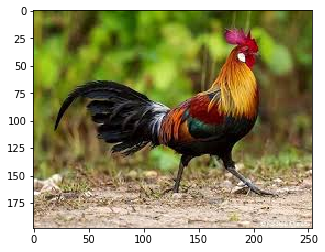

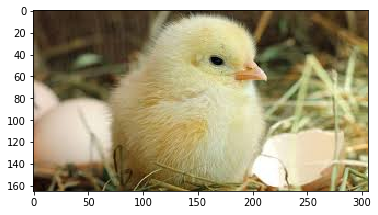

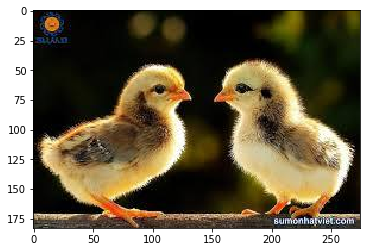

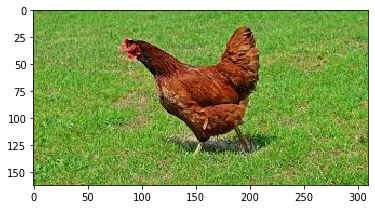

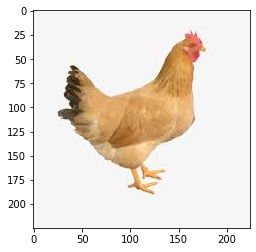

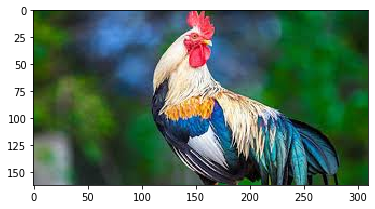

In [33]:
for path in sample_image_list:
    img = cv2.imread(path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    #cv2.imshow('image',img)
    #cv2.waitKey(0)


array([1, 0, 0, 2, 2, 1])